In [2]:
import numpy as np
import scipy as sp
from scipy.stats import unitary_group
from datetime import datetime
import matplotlib.pyplot as plt
import os
import uuid
from itertools import repeat, chain, product, combinations
from joblib import Parallel, delayed
import time
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM, load_random_exp_povm
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from EMQST_lib import clustering as cl
from functools import reduce
import scipy.cluster.hierarchy as sch
np.set_printoptions(precision=3)
%load_ext autoreload
%autoreload 2


## Scalable QREM.

We start out by considering separable states for both simple simulationa and very scalable results. 

For scalable QREM it is only nessecary to use $k = 2$ hashes. We will however use $k = 4$ hashes to make sure we can easily ask for arbitrary correlators afterwards, without changing the base code. 

### Overlapping tomography: 
For this we require a perfect family of hashing functions, denoted by $(N,k,m,m)$, where $N$ is the total number of hashing fuctions, $k$ is the size of the total system and m is the size of the subsystem you want to reconstruct arbitrary correlators. The number of hashing functions scales exponentially in $k$, but logarithmically in $m$.


### Step by step layout of the separable state code
1. Perform efficient Quantum detector overlapping tomography (QDOT)
    1. Create/load the hashing for the spesified protocol.
    2. Overlapping QDT
        1. Create a set of calibration states according to hashing function. This is effectivly to split total system up into $m$ subgroups that are effectivly treated as a single qubit. This means the set of calibration states scales as $4^m$.
        2. For each hashing function, measure the complete set of calibration states in the computational basis. 
    3. Perform overlapping tomography measurements. (See original paper [here](https://link.aps.org/doi/10.1103/PhysRevLett.124.100401), a more efficient variant for 2-local RDMS can be found [here](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.023393))
        1. Use the same hashing functions from step 1. and create a set of Pauli-6 measurements from these hashing functions. (Similarly as before, it splits the whole system into $m$ subsystems that are effecitvly treated as a single qubit. One then perform an IC POVM on these effective single qubits.) Each hasing function is a different assignment over the whole qubit system.
        2. Measure the qubit system of interest with the hashed Pauli-6 POVMs.
    4. Save all results to file.

2. Extract correlation strucutre
    1. Reconstruct all possible 2 qubit POVM between all the qubits.
    2. Extract the quantum correlation coefficients from each 2 qubit POVM.
    3. Use a cluster-finding algorithm to assign a cluster structure to all qubits 
    4. Redo QDT with the found cluster structure (if not already used $k = 4$ QDOT earlier)
    5. Reconstruct the POVMs on the found noise clusters.
    
3. Perform error mitigated QST. Since we assume the underlying states are separable, there is no limit to how large the correlators we can estimate are. 
    1. Perform IC QST measurments on all clusters.
    2. Reconstruct the state on each cluster. This gives total cluster state $\rightarrow \rho = \otimes_s \rho_s$ for $s\in$ clusters. 
    3. Compute correlators as $Tr(O\rho)$ where $O$ is some operator (this can be done efficiently as the max subsystem size is capped. )

4. (Optionally) Compare to other methods, such as classial only. Correlator only, separable only....

## 1. QDOT

Define simulation parameters.
Select POVM noise:
1. Generate artifical noise sources
    1. Single qubit depolarzing noise
    2. Unitary cluster noise (randomly generates cluster sizes from 0 to cluster_cap)
    3. 2 qubit (CNOT or ISWAP) between neighboring qubits, factorized i.e. all clusters are of size 2.
2. Load noisy POVM from experimental run. 

In [ ]:
# Define parameters
n_QST_shots = 10**3
n_QDT_shots = 10**4
n_hash_symbols = 4
n_qubits = 16
use_chunks = True # If true, the nois POVMs and sampled will be split into chunks of chunk_size, 
                 # and sampled as genuine chunk-qubit states. Nessecary for entangled states. 
chunk_size = 4 # For entangled sampling states
n_chunks = int(n_qubits/chunk_size)
path = f"EMQST_lib/hash_family/"
save_raw_data = False # If false, only processes data will be saved. If true, raw sample data will be saved as well. 
n_cores = 9




# 1.1. Load/create the hashing use for protocol
if n_hash_symbols>2:
    hash_family = None
    for files in os.listdir(path):
        if files.endswith(f"{n_qubits},{n_hash_symbols}).npy"):
            print(files)
            with open(f'{path}{files}' ,'rb') as f:
                hash_family = np.load(f)
            break # This break is to make sure it does not load a worse hash if it is stored.
    if hash_family is None: 
        raise ValueError("Did not find hash for this combination, please change settings or create relevant perfect hash family.")
else: # For k=2 we can use the 2-RDM hash family
    hash_family = ot.create_2RDM_hash(n_qubits)
n_hashes = len(hash_family)

print("The shot budget of the currents settings are:")
print(f'QDT shots for computational basis reconstruction: {(n_hashes*(4**n_hash_symbols -4) +4):,} x {n_QDT_shots:,}.')
print(f'QST shots for arbitrary {n_hash_symbols}-RDM reconstruction: {(n_hashes*(3**n_hash_symbols -3) +3):,} x {n_QST_shots:,}.')

experimental_run = False
noise_mode = 4
exp_povms_used =[] # array that contains the POVMs used from the experimental list
path_to_experimental_POVMs = "Exp_povms/Extracted_modified"
# Decides noise mode:
# 0: Noiseless measurement
# 1: Single qubit depolarizing noise
# 2: Random chunk-sized qubit noise
# 3: Import random experimental noisy POVM from path (strong noise)
# 4: Import random experimental noisy Z-basis POVM from path
# 5: Random strenght CNOT noise (2 qubit noise)

# Create povm that is applied to each qubit.
single_qubit_comp_POVM = POVM.generate_computational_POVM(1)[0]


if experimental_run:
    print('Experimental run')	
    single_qubit_pauli_6 = POVM.generate_Pauli_POVM(1) 
    comp_POVM_array = np.array([single_qubit_comp_POVM]*n_qubits)
    
    # These following are only needed for the simulation
else: 
    if noise_mode:
        print(f'Noisy measurement, noise mode {noise_mode}')
        if noise_mode == 1: # Single qubit depolarizing noise
            noisy_POVM = POVM.depolarized_POVM(single_qubit_comp_POVM)
            povm_array = np.array([noisy_POVM]*n_qubits)
            single_qubit_pauli_6 = np.array([POVM.depolarized_POVM(povm) for povm in POVM.generate_Pauli_POVM(1) ])
            cluster_size = np.ones(n_qubits, dtype=int)
            n_clusters = n_qubits
            
        
        elif noise_mode == 2 or noise_mode == 3 or noise_mode == 4: # Nontirival cluster noise, that conforms to chunk_size:
            # Mode == 2 is random unitary noise
            # Mode == 3 is extracted from POVMs. 
            # This mode has a variable number of qubits in each cluster, and the noise is applied to the clusters.
            # We create a set number of clusters with different number of qubits in each cluster., capped at 5 qubits.
            print(f"Non-trivial cluster noise")
            if noise_mode == 2: 
                print(f'Using random unitary noise.')
            if noise_mode == 3:
                print(f'Using random noisy POVMs selected from experiments.')
            if noise_mode == 4:
                print(f'Using random noisy Z-basis POVMs selected from experiments')
            cluster_cap = 4 # Caps local POVM correlation
            #cluster_size = ot.generate_chunk_sizes(chunk_size, n_chunks, cluster_cap)
            
            print("Using fixed cluster sizes")
            cluster_size = np.array([4, 1, 3, 2, 2, 1, 2, 1])
            print(cluster_size)
            n_clusters = len(cluster_size)
    

            print(f'The total number of qubits are {sum(cluster_size)}, with {n_clusters} clusters.' )
            print(cluster_size)
            #povm_array = [POVM.generate_random_POVM(2,2) ,POVM.generate_random_POVM(2,2), POVM.generate_noisy_POVM(POVM.generate_computational_POVM(2)[0],3)]
            povm_array = []
            for size in cluster_size:
                if noise_mode == 2:
                    comp_povm = POVM.generate_computational_POVM(size)[0]
                    base_POVM_list = comp_povm.get_POVM()
                    #depol = POVM.depolarized_POVM(comp_povm,np.random.rand())
                    #noisy_POVM = POVM.generate_random_POVM(2**size,2**size)#POVM.generate_noisy_POVM(comp_povm,1)
                    noise_transformation = unitary_group.rvs(2**size)
                    k = 0.7 # Mixing strenght (probability)
                    noisy_POVM_list=POVM(k*base_POVM_list + (1-k)*np.einsum('jk,ikl,lm->ijm',noise_transformation.conj().T,base_POVM_list,noise_transformation))
                elif noise_mode == 3:
                    noisy_POVM_list, load_path = load_random_exp_povm(path_to_experimental_POVMs, size)
                    exp_povms_used.append(load_path)
                elif noise_mode == 4:
                    noisy_POVM_list, load_path = load_random_exp_povm(path_to_experimental_POVMs, size, use_Z_basis_only=True)
                    exp_povms_used.append(load_path)
                    
                povm_array.append(noisy_POVM_list)


        elif noise_mode == 5: # Random strenght CNOT noise
            print(f'Random strenght CNOT/ISWAP noise.')
            cluster_cap = 3
            cluster_size = np.ones(int(n_qubits/2),dtype=int)*2
            n_clusters = len(cluster_size)
            local_noise_mode = 1
            print(f'The total number of qubits are {sum(cluster_size)}, with {n_clusters} clusters.' )
            comp_povm_array = POVM.generate_computational_POVM(2)[0].get_POVM()
            
            CNOT=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]],dtype=complex)
            ISWAP=np.array([[1,0,0,0],[0,0,1j,0],[0,1j,0,0],[0,0,0,1]],dtype=complex)
 
            noise_transformation = ISWAP
            random_strenght =  np.random.random(int(n_qubits/2))*0.4 + 0.5 # Mixing strenght (probability)
            print(random_strenght)
            povm_array = [POVM(k*comp_povm_array + (1-k)*np.einsum('jk,ikl,lm->ijm',noise_transformation.conj().T,comp_povm_array,noise_transformation)) for k in random_strenght]

            #povm_array = [POVM.generate_noisy_POVM(comp_povm,local_noise_mode)]*n_clusters
        
    else:
        print('Noiseless measurement')
        povm_array = np.array([single_qubit_comp_POVM]*n_qubits)
        single_qubit_pauli_6 = POVM.generate_Pauli_POVM(1) 



# Generate true states, will have shapes # [[theta,phi], ... ] theta in [0,pi], phi in [-pi,pi]
#rho_true_array = np.array([sf.generate_random_pure_state(1) for _ in range(n_qubits)])
#rho_true_angle_array = np.array([sf.get_angles_from_density_matrix_single_qubit(state)[0] for state in rho_true_array])  


# Define an IC calibration basis, here we use the SIC states (by defining the angles (as will be used for state preparation))
one_qubit_calibration_angles = np.array([[[0,0]],[[2*np.arccos(1/np.sqrt(3)),0]],
                                                 [[2*np.arccos(1/np.sqrt(3)),2*np.pi/3]],
                                                 [[2*np.arccos(1/np.sqrt(3)),4*np.pi/3]]])
one_qubit_calibration_states=np.array([sf.get_density_matrix_from_angles(angle) for angle in one_qubit_calibration_angles])


# These are the instructions that that need to be applied to each qubit.
possible_QDT_instructions = np.array([0, 1, 2, 3]) # For QDT we need to measure each of the 4 calibration states.  
# Experiment equivalent =  one_qubit_calibration_angles
possible_QST_instructions = np.array(["X", "Y", "Z"]) # For QST we need to meaure each qubit in the 3 Pauli basis.
# Experiment equivalent = [[pi/2, 0], [pi/2, pi/2], [0,0]]
 
 
# Define the experimental dictionary
def exp_measurement_func(n_shots, measurement_angle, state_angle, experimental_dictionary):
    """
    This is a mock function for experimental calls. 

    Inputs:
    - n_shots: The number of measurement shots to perform.
    - state_angle: The angle of the state preparation. Has shape (n_qubits, 2).
    - measurement_angle: The angle of the measurement basis. Has shape (n_qubits, 2).
    - experimental_dictionary: A dictionary containing experimental parameters.

    Outputs:
    - results: An np.array of shape (n_shots, n_qubits) representing the measurement outcomes (0 or 1) for each qubit.
    """
    print('Running experimental function')
    print('State angle:', state_angle)
    print('Measurement angle:', measurement_angle)
    print('Returning random results.')
    return np.random.randint(0, 2, (n_shots, n_qubits))
    
# experimental_dictionary = {"experimental_run": experimental_run,
#                            "standard_measurement_function" : exp_measurement_func,
#                            "true_state_angles" : rho_true_angle_array,
#                            "single_qubit_measurement_angles" : np.array([[np.pi/2, 0], [np.pi/2, np.pi/2], [0,0]]),
#                            "comp_measurement_angles" : np.array([[0,0]]*n_qubits),
#                            "one_qubit_calibration_angles" : one_qubit_calibration_angles.reshape(-1,2) # Redefine shape to have correct format.
#                            } # add any other experimental parameters here, even another dictionary.

QDOT_run_dictionary = {
    "n_QST_shots": n_QST_shots,
    "n_QDT_shots": n_QDT_shots,
    "n_hash_symbols": n_hash_symbols,
    "n_qubits": n_qubits,
    "n_cores": n_cores,
    "hash_family": hash_family,
    "n_hashes": n_hashes,
    "experimental_run": experimental_run,
    "noise_mode": noise_mode,
    "povm_array": [povm.get_POVM() for povm in povm_array], # Can be of inhomogenious shape.
    "noise_cluster_size": cluster_size,
    "n_clusters": n_clusters,
    "possible_QDT_instructions": possible_QDT_instructions,
    "possible_QST_instructions": possible_QST_instructions,
    "exp_POVMs_loaded" : exp_povms_used # List of paths to to POVMs used in the noise sumulations. 
    #"experimental_dictionary": experimental_dictionary,
    }

# Create QDT instructions based on hashing (covering arrays) 
hashed_QDT_instructions = ot.create_hashed_instructions(hash_family, possible_QDT_instructions, n_hash_symbols)
# Create hashed calibration states
hashed_calib_states = np.array([ot.calibration_states_from_instruction(instruction, one_qubit_calibration_states) for instruction in hashed_QDT_instructions])
print('Hashed calibration states shape:', hashed_calib_states.shape)

# Simulate all instruction measurements
print(f'Simulating QDT measurements for {n_qubits} qubits.')
QDT_outcomes_parallel = Parallel(n_jobs = n_cores, verbose = 5)(delayed(mf.measure_clusters)(n_QDT_shots, povm_array, rho_array, cluster_size) for rho_array in hashed_calib_states)
QDT_outcomes = np.asarray(QDT_outcomes_parallel)

print('QDT outcomes shape:', QDT_outcomes.shape)

# Make saving folder for this run
# Check if restuls exist:
check_path='QDOT_results'
path_exists=os.path.exists(check_path)
if not path_exists:
    print("Created QDOT_results dictionary.")
    os.makedirs('QDOT_results')

# Generate new dictionary for current run
now=datetime.now()
now_string = now.strftime("%Y-%m-%d_%H-%M-%S_")
dir_name= now_string+str(uuid.uuid4())


data_path=f'QDOT_results/{dir_name}'
os.mkdir(data_path)


# Save run settings
with open(f'{data_path}/run_settings.npy','wb') as f:
    np.save(f,QDOT_run_dictionary)


perfect_hash(9,16,4).npy
The shot budget of the currents settings are:
QDT shots for computational basis reconstruction: 2,272 x 10,000.
QST shots for arbitrary 4-RDM reconstruction: 705 x 1,000.
Noisy measurement, noise mode 4
Non-trivial cluster noise
Using random noisy Z-basis POVMs selected from experiments
Using fixed cluster sizes
[4 1 3 2 2 1 2 1]
The total number of qubits are 16, with 8 clusters.
[4 1 3 2 2 1 2 1]
['Exp_povms/Extracted_modified/4\\q0q1q2q3\\2024-10-11_01-58-42_59eee374-2e12-4395-919b-eac23ff6a261\\DT_settings.npy', 'Exp_povms/Extracted_modified/4\\q0q1q2q3\\2024-10-11_03-55-39_5961b0a3-ce29-4aca-bc5c-8fc954231421\\DT_settings.npy', 'Exp_povms/Extracted_modified/4\\q0q1q2q3\\2024-10-11_05-52-38_1250b283-2054-4c37-b11e-204f1772d8ba\\DT_settings.npy', 'Exp_povms/Extracted_modified/4\\q0q1q2q3\\2024-10-11_07-49-26_69f895b1-b0d3-4df6-9cc9-14ea3f4b4169\\DT_settings.npy']
['Exp_povms/Extracted_modified/1\\q0\\2024-10-13_09-15-44_a859b1ef-dcdd-43d8-8904-ff4dcae1850c\\

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   10.6s
[Parallel(n_jobs=9)]: Done 531 tasks      | elapsed:   11.9s
[Parallel(n_jobs=9)]: Done 1539 tasks      | elapsed:   14.5s
[Parallel(n_jobs=9)]: Done 2255 out of 2272 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=9)]: Done 2272 out of 2272 | elapsed:   16.3s finished


QDT outcomes shape: (2272, 10000, 16)


## 2. Extract correlator structure
Creates 2 qubit POVMs used for correlation extraction. Steps:
1) Creates hash instructions
2) Simulates QDT measurements
3) Reconstructs all possible 2 qubit POVMs. 

Computes the correlation coefficients and then uses them to find the correlation strucutre

In [490]:
print(f'Create all possible 2 qubit POVMs for correlation map.')
two_point_POVM, corr_subsystem_labels = ot.reconstruct_all_two_qubit_POVMs(QDT_outcomes, n_qubits, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)

summed_quantum_corr_array, unique_corr_labels = ot.compute_quantum_correlation_coefficients(two_point_POVM, corr_subsystem_labels)
dist_matrix_WC = cl.create_distance_matrix_from_corr(summed_quantum_corr_array, unique_corr_labels, n_qubits)

# summed_quantum_corr_array_AC, unique_corr_labels_AC = ot.compute_quantum_correlation_coefficients(two_point_POVM, corr_subsystem_labels, mode = "AC")
# dist_matrix_AC = cl.create_distance_matrix_from_corr(summed_quantum_corr_array_AC, unique_corr_labels_AC, n_qubits)

Create all possible 2 qubit POVMs for correlation map.
Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   24.2s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   51.2s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    8.9s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   16.5s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   23.8s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   31.4s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   38.6s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   46.3s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:  1.0min
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:  1.2min
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:  1.4min
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:  1.8min remaining:    3.6s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:  1.9min finished


Fluctuation limit: 0.01
Found cluster lables:
 WC: [[8, 9], [12, 13], [14, 15], [1, 2], [6, 7], [4, 5], [0], [10], [3], [11]]


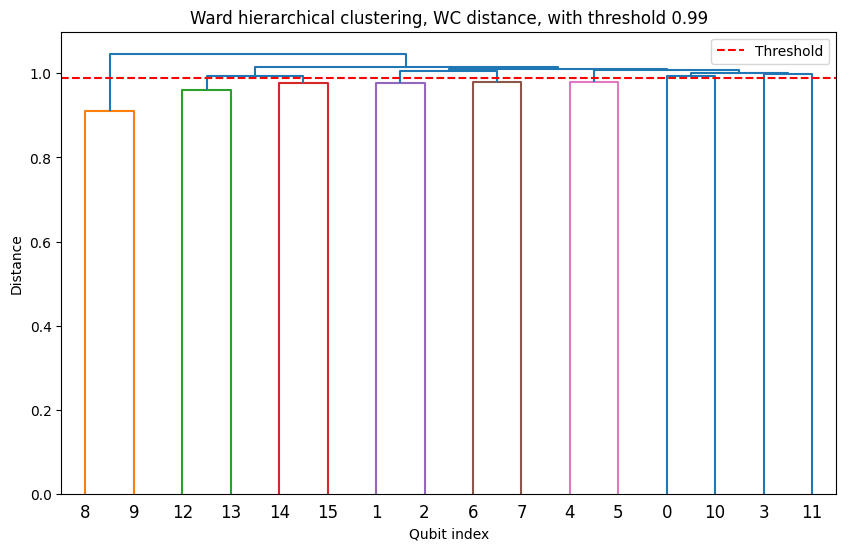

In [ ]:
fluctuation_limit = 1/np.sqrt(n_QDT_shots)
thr = 1 - fluctuation_limit
print(f'Fluctuation limit: {fluctuation_limit}')	
fcluster_labels_WC, Z_WC = cl.ward_clustering(dist_matrix_WC, thr)

print(f'Found cluster lables:\n WC: {cl.fcluster_to_labels(fcluster_labels_WC)}')
# Create the dendrogram

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
dn1 = sch.dendrogram(Z_WC, ax=ax, above_threshold_color='C0',
                           orientation='top', color_threshold=thr)


ax.plot([0, 1000], [thr, thr], 'r--',  label = 'Threshold' )
ax.set_ylabel('Distance')
ax.set_xlabel('Qubit index')
    #axes[i].set_ylim([0., 1.4])
ax.set_title(f'Ward hierarchical clustering, WC distance, with threshold {thr}')

ax.legend()
sch.set_link_color_palette(None)  # reset to default after use

# If clustering is too large:
cluster_sizes = [len(item) for item in cl.fcluster_to_labels(fcluster_labels_WC)]
max_cluster_size = 4
if max(cluster_sizes) > max_cluster_size:
    print("Initial Cluster Assignments:", cl.fcluster_to_labels(fcluster_labels_WC))

    # Split large clusters
    max_size = 4
    final_assignments = cl.split_large_clusters(dist_matrix_WC, fcluster_labels_WC, max_size)
    tuned_labels = cl.fcluster_to_labels(final_assignments)
    print("Final Cluster Assignments:", tuned_labels)

Fluctuation limit: 0.01
Found cluster lables:
AC: [[12, 13], [8, 10], [9], [14, 15], [3], [4, 5], [0], [11], [1, 2], [6, 7]]
WC: [[12, 13], [14, 15], [3], [8, 9, 10], [4, 5], [0], [11], [1, 2], [6, 7]]


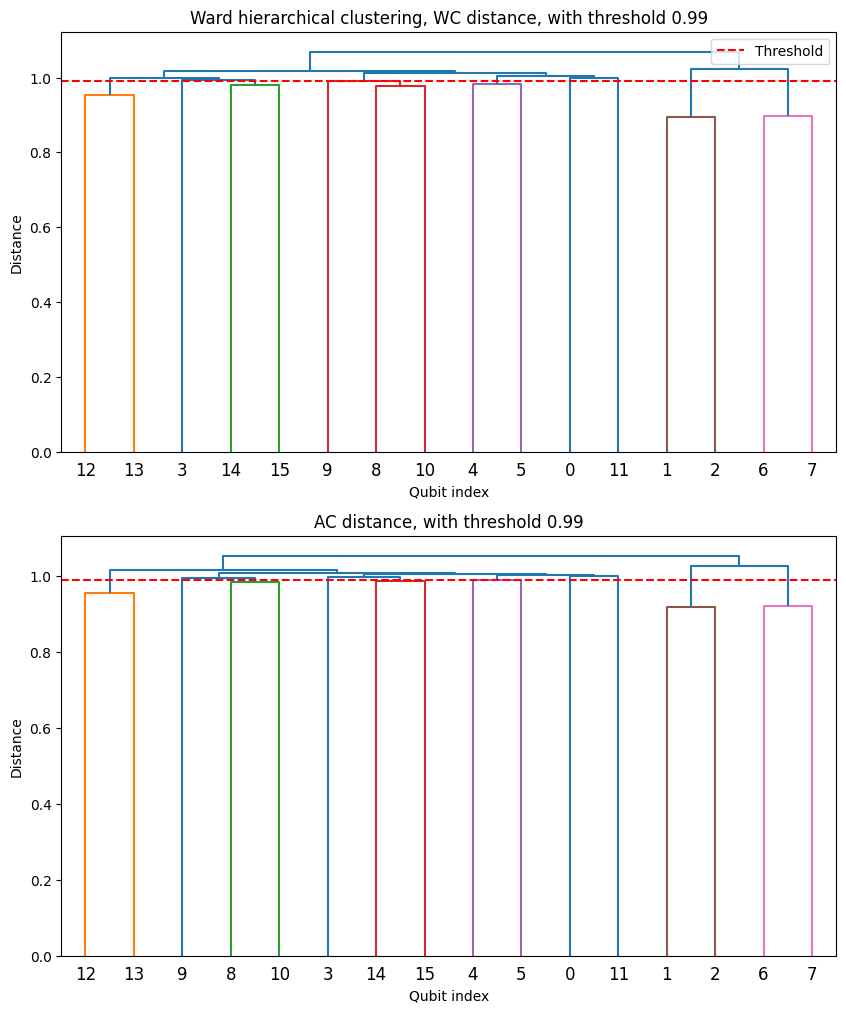

In [ ]:



fluctuation_limit = 1/np.sqrt(n_QDT_shots)
thr = 1 - fluctuation_limit
print(f'Fluctuation limit: {fluctuation_limit}')	
fcluster_labels_WC, Z_WC = cl.ward_clustering(dist_matrix_WC, thr)
fcluster_labels_AC, Z_AC = cl.ward_clustering(dist_matrix_AC, thr)


print(f'Found cluster lables:\nAC: {cl.fcluster_to_labels(fcluster_labels_AC)}\nWC: {cl.fcluster_to_labels(fcluster_labels_WC)}')
# Create the dendrogram

fig, axes = plt.subplots(2, 1, figsize=(10, 12))
dn1 = sch.dendrogram(Z_WC, ax=axes[0], above_threshold_color='C0',
                           orientation='top', color_threshold=thr)
dn2 = sch.dendrogram(Z_AC, ax=axes[1],
                           above_threshold_color='C0',
                           orientation='top', color_threshold=thr)
for i in range(len(axes)):
    axes[i].plot([0, 1000], [thr, thr], 'r--',  label = 'Threshold' )
    axes[i].set_ylabel('Distance')
    axes[i].set_xlabel('Qubit index')
    #axes[i].set_ylim([0., 1.4])
axes[0].set_title(f'Ward hierarchical clustering, WC distance, with threshold {thr}')
axes[1].set_title(f'AC distance, with threshold {thr}')
axes[0].legend()
sch.set_link_color_palette(None)  # reset to default after use

# If clustering is too large:
cluster_sizes = [len(item) for item in cl.fcluster_to_labels(fcluster_labels_WC)]
max_cluster_size = 4
if max(cluster_sizes) > max_cluster_size:
    print("Initial Cluster Assignments:", cl.fcluster_to_labels(fcluster_labels_WC))

    # Split large clusters
    max_size = 4
    final_assignments = cl.split_large_clusters(dist_matrix_WC, fcluster_labels_WC, max_size)
    tuned_labels = cl.fcluster_to_labels(final_assignments)
    print("Final Cluster Assignments:", tuned_labels)


In [ ]:
# # Compute the quantum correlation coefficients with worst case distance
noise_cluster_labels = cl.find_noise_cluster_structure(QDT_outcomes, n_qubits, n_QDT_shots, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)
    
print(f'Noise cluster: {noise_cluster_labels}')
print(f'')

# # Save the correlation data
# correlation_dict = {
#     "quantum_corr_array": quantum_corr_array,
#     "classical_corr_array": classical_corr_array,
#     "unique_corr_labels": unique_corr_labels,
#     "summed_quantum_corr_array": summed_quantum_corr_array,
#     #"quantum_corr_array_AC": quantum_corr_array_AC,
#     #"classical_corr_array_AC": classical_corr_array_AC,
#     "noise_cluster_labels": noise_cluster_labels
# }
# with open(f'{data_path}/cluster_correlation.npy', 'wb') as f:
#     np.save(f, correlation_dict)
    
true_cluster_labels = ot.get_true_cluster_labels(cluster_size)
print(f"True labels: {true_cluster_labels}")

Create all possible 2 qubit POVMs for correlation map.
Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   20.9s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   45.5s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    9.9s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   20.5s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   30.3s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   40.5s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   51.5s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:  1.1min
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:  1.3min
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:  1.5min
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:  1.8min
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:  2.0min remaining:    4.1s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:  2.1min finished


Alpha: 0.0
Starting optimization of premade cluster structure.
Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Starting optimization of premade cluster structure.
Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Found cluster structure
 [[5, 4], [9, 8, 0], [11, 10, 3], [13, 12, 14, 15], [2, 1, 7, 6]], 
[[13, 14, 12, 15], [2, 1, 10, 11], [5, 8, 4, 9], [7, 0, 6, 3]]
Found reward 0.5096318219624928, 0.503646796226068
New reward: 0.5096318219624928
New cluster labels: [[5, 4], [9, 8, 0], [11, 10, 3], [13, 12, 14, 15], [2, 1, 7, 6]]
Alpha: 0.4
Starting optimization of premade cluster structure.
Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Starting optimization of premade cluster structure.
Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Found cluster structure
 [[5, 4], [11, 10], [7, 6], [0], [3], [8, 9], [2, 1], [13, 12, 15, 14]], 
[[0], [8, 9], [4, 5], [6, 7], [1, 12, 13, 15], [10, 11], [2], [3], [14]]
Found reward 0.09280977549028868, 0.08635662107990144
Alpha: 0.5
Starting optimization of premade cluster structure.
Run: 0
Run: 1
Run: 2

Create all the POVMs from the found cluster states

In [12]:
#[[7, 6], [9, 8], [0], [11, 10, 3, 14], [13, 12, 15], [5, 4, 2, 1]]
# Assume perfect noise cluster structure
# true_cluster_labels = ot.get_true_cluster_labels(cluster_size)
# noise_cluster_labels = true_cluster_labels

clustered_QDOT = ot.reconstruct_POVMs_from_noise_labels(QDT_outcomes,noise_cluster_labels, n_qubits, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)
#with open('clustered_QDOT.npy', 'wb') as f:
with open(f'{data_path}/clustered_QDOT.npy', 'wb') as f:
    QDT_dict = {
        "clustered_QDOT": [povm.get_POVM() for povm in clustered_QDOT],
    }
    np.save(f, QDT_dict)

#del QDT_outcomes


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   8 | elapsed:    6.0s remaining:   18.2s
[Parallel(n_jobs=9)]: Done   3 out of   8 | elapsed:    6.0s remaining:   10.1s
[Parallel(n_jobs=9)]: Done   4 out of   8 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=9)]: Done   5 out of   8 | elapsed:    8.6s remaining:    5.1s
[Parallel(n_jobs=9)]: Done   6 out of   8 | elapsed:    8.6s remaining:    2.8s
[Parallel(n_jobs=9)]: Done   8 out of   8 | elapsed:   53.0s finished


In [9]:
# Compare to true POMVs. 
print(noise_cluster_labels)
# comparison_array = np.array([6,0,5,4,3,8,2,7,1])[::-1]

for i, item in enumerate(clustered_QDOT):
    a = item.get_POVM()
    print(a.shape)
    print(sf.ac_POVM_distance(povm_array[i].get_POVM(),clustered_QDOT[i].get_POVM()))


[array([12, 13, 14, 15]), array([10, 11]), array([8, 9]), array([6, 7]), array([4, 5]), array([3]), array([1, 2]), array([0])]
(16, 16, 16)
0.010278893285581025
(4, 4, 4)
0.000736975950051455
(4, 4, 4)
0.0008585214496233048
(4, 4, 4)
0.0009546092912656635
(4, 4, 4)
0.0010145341356741083
(2, 2, 2)
0.0002248749608283949
(4, 4, 4)
0.0007909532895664913
(2, 2, 2)
8.129442650833163e-05


## 3. QST

We do comparison between multiple different approaches to do cluster based readout error mitigation. 

1) No QREM (do nothing special, reconstruct 2RDM based on noisy measurements).
2) Facotrized QREM. 
    Use single qubit QREM and tensor together results.  
3) REM on correlator qubits only.
4) Premade cluster POVM-reduction method. Thus outdated method is based on tracing down the POVM with knowledge of the state of the enviourment that is correlated to the state. Was underperforming. IT is designd as follows: 
    1) Trace down POVM of the cluster POVMs such that only dimension of two-point qubits are left. 
    2) In QST, use the POVM elemet that corresponds to the outcome on the full cluster. 
    3) Estimated state comes out to the corect shape. No more tracing required. 
5) Premade cluster state-reduction method.  Here we use the pre-made custer and reconstruct the state on these clusters indepdendently. Then trace down the relevant cluster states to 2RDM (either factorized from two differnet clusters or two within the same cluster). The steps are as follow:
    1) Reconstruction of the states for the clusters structure.
    2) Find the the correct cluster indecies for those cluster structures. 
    3) Trace down the states to get the correct product states.
    4) If correlator is in two different clusters, tensor together two single qubit states. 

6) Premade cluster state-reduction method with classical errors only. 
7) Entangled cluster reconstruction. 

### Entangled state simulation only


In [531]:
hashed_QST_instructions = ot.create_hashed_instructions(hash_family, possible_QST_instructions, n_hash_symbols)
# Generates GHZ states on the whole system (the total )

state_size_array = [chunk_size]*int(n_qubits/chunk_size)	# Set size to max to make sure state is entangled inside the chunk
rho_true_array = [sf.generate_GHZ(size) for size in state_size_array]

rho_true_labels = ot.get_true_cluster_labels(state_size_array)

povm_true_labels = ot.get_true_cluster_labels(cluster_size)
print(f'Noise cluster: {noise_cluster_labels}')
print(f'State size array: {state_size_array}')    
print(f'Label structure rho_true : {rho_true_labels}')
print(f'Label structure POVM: {povm_true_labels}')

n_QST_shots_total = n_QST_shots *1
# Sample hashes outcomes to be used by most comparisons. 
QST_outcomes = mf.measure_hashed_chunk_QST(n_QST_shots_total, chunk_size, povm_array, cluster_size, rho_true_array, state_size_array, hashed_QST_instructions)


# Define the two point correlators to extract: 
# two_point_array = ot.generate_random_pairs_of_qubits(n_qubits,5) # ,[7,9] [3,5]
two_point_array = np.array([[13, 12]])#, [8,10], [4,7],[0,1]])


entangled_recon_states, entangled_qubit_order = ot.entangled_state_reduction_premade_clusters_QST(two_point_array,
                        noise_cluster_labels, QST_outcomes, clustered_QDOT, hash_family, n_hash_symbols, n_qubits)
# 3 qubits: 4.sec old efficient , 2.8 new_efficient , old 2 sec, old with optimization 1.5 sec  
# 4 qubits: old efficient 38, new_efficient 35, old 27 sec, old with optimization 16 sec
# 5 qubits: old efficient 2.5 min  min, new efficient 2.5 min, old 3 min, old with optimization 1.25 min
# 6 qubits old efficient 16.5 min, new efficient 16.7 min, old min 37+ min, old with optimization 43  mins
# 7 qubits old efficient 30.5 mins, new efficient 28 mins
# 8 Qubits old efficient hours, new efficient 14 hours

# Compare the minimal chunk state with the entangled reconstructed states. 
# Reconstruct relevant states
print(entangled_recon_states[0].shape)
rho_true_list, rho_labels_in_state = ot.tensor_chunk_states(rho_true_array, rho_true_labels, noise_cluster_labels, two_point_array)

traced_down_rho_true = [ot.trace_down_qubit_state(rho_true_list[i], rho_labels_in_state[i], np.setdiff1d(rho_labels_in_state[i], entangled_qubit_order[i])) for i in range(len(rho_true_list))]
Z = np.array([[1,0],[0,-1]])
id = np.array([[1,0],[0,1]])
# array = [Z, id,id,Z]
# operator = reduce(np.kron, array)
# These are now cluster reconstructed states that are entangled.
for rho_true, rho_recon in zip(traced_down_rho_true, entangled_recon_states):
    print(f'Qubit infidelitliy of traced down state: {sf.qubit_infidelity(rho_recon, rho_true)}')
    # print(np.trace(operator @ rho_recon))
    # print(np.trace(operator @ rho_true))

Noise cluster: [[9, 8], [12, 13, 15], [5, 4], [7, 6], [1, 2, 14], [10, 0], [11, 3]]
State size array: [4, 4, 4, 4]
Label structure rho_true : [array([15, 14, 13, 12]), array([11, 10,  9,  8]), array([7, 6, 5, 4]), array([3, 2, 1, 0])]
Label structure POVM: [array([15, 14, 13, 12]), array([11]), array([10,  9,  8]), array([7, 6]), array([5, 4]), array([3]), array([2, 1]), array([0])]


NameError: name 'clustered_QDOT' is not defined

Testing method where we only measure the relevant qubits. Allows us more to more efficiently handle the larger qubit sizes. 

In [ ]:
print(f'Noise cluster: {noise_cluster_labels}')
print(f'State size array: {state_size_array}')    
print(f'Label structure rho_true : {rho_true_labels}')
print(f'Label structure POVM: {povm_true_labels}')

total_shots = n_QST_shots

#ideal_povm = [POVM.generate_computational_POVM(len(size))[0] for size in noise_cluster_labels]
holder = [mf.measure_and_QST_target_qubit_only(two_point,noise_cluster_labels, total_shots, n_qubits, chunk_size, 
                           povm_array, cluster_size, rho_true_array, state_size_array,clustered_QDOT) 
          for two_point in two_point_array]
# entangled_recon_states, entangled_qubit_order = ot.entangled_state_reduction_premade_clusters_QST(two_point_corr,
#                         noise_cluster_labels, QST_outcomes, clustered_QDOT, hash_family, n_hash_symbols, n_qubits)

#rho_recon_2 = ot.QST_from_instructions(QST_outcomes, QST_only_instructions,two_point_array, target_qubits, clustered_QDOT, noise_cluster_labels, n_qubits)

target_qubits = []
rho_recon = []
for item in holder:
    rho_recon.append(item[0])
    target_qubits.append(item[1])
rho_true_list, rho_labels_in_state = ot.tensor_chunk_states(rho_true_array, rho_true_labels, noise_cluster_labels, two_point_array)
traced_down_rho_true = [ot.trace_down_qubit_state(rho_true_list[i], rho_labels_in_state[i], np.setdiff1d(rho_labels_in_state[i],target_qubits[i]))
                        for i in range(len(rho_true_list))]



# These are now cluster reconstructed states that are entangled.
for rho_true, rho_recon in zip(traced_down_rho_true,rho_recon):
    print(f'Qubit infidelitliy of traced down state: {sf.qubit_infidelity(rho_recon, rho_true)}')
    # print(np.trace(operator @ rho_recon))
    # print(np.trace(operator @ rho_true))

Noise cluster: [[11, 10], [5, 4], [8], [9], [0], [3], [2, 1, 13, 15], [7, 6, 14, 12]]
State size array: [4, 4, 4, 4]
Label structure rho_true : [array([12, 13, 14, 15]), array([ 8,  9, 10, 11]), array([4, 5, 6, 7]), array([0, 1, 2, 3])]
Label structure POVM: [array([12, 13, 14, 15]), array([10, 11]), array([8, 9]), array([6, 7]), array([4, 5]), array([3]), array([1, 2]), array([0])]
Target Qubits: [15 14 13 12  7  6  2  1]
relevant cluster index [6, 7]
relevant cluster labels [array([15, 13,  2,  1]), array([14, 12,  7,  6])]
POVM size: (4, 4, 4)
POVM size: (4, 4, 4)
POVM size: (2, 2, 2)
POVM size: (2, 2, 2)
POVM size: (2, 2, 2)
POVM size: (2, 2, 2)
POVM size: (16, 16, 16)
POVM size: (16, 16, 16)
tensored povm size :(256, 256, 256)
POVM shape (256, 256, 256)
(6561, 256, 256)
(256, 256, 256)
(6561, 256)


### Comparative simulations

## Comparing data and plotting

### Plotting ZZ correlators and finidelities (outdated)

In [ ]:
# Operational boosl:
assume_perfect_clustering = True # If true, we will use the perfect, and the noise is applied to the clusters.
assume_perfect_QDT = False # If true, we will use the perfect noisy POVMs, overrised perfect clustering, as it needs to be perfect.

true_cluster_labels = cl.get_true_cluster_labels(cluster_size)
two_point_corr_labels = np.array([[0, 3],[10,11],[14,15]])

one_qubit_POVMs = ot.reconstruct_all_one_qubit_POVMs(QDT_outcomes, n_qubits, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)

# Reconstruct spesiffic two_point_povms
two_point_POVM = ot.reconstruct_spesific_two_qubit_POVMs(QDT_outcomes, two_point_corr_labels , n_qubits, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)

if assume_perfect_QDT:
    clustered_QDOT = povm_array

elif assume_perfect_clustering:
    noise_cluster_labels = true_cluster_labels
    clustered_QDOT = ot.reconstruct_POVMs_from_noise_labels(QDT_outcomes, ot.get_true_cluster_labels(cluster_size), n_qubits, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)
else:
    noise_cluster_labels = ot.find_noise_cluster_structure(QDT_outcomes, n_qubits, n_QDT_shots, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)
    clustered_QDOT = ot.reconstruct_POVMs_from_noise_labels(QDT_outcomes, noise_cluster_labels, n_qubits, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)
    
    
print(f"Noise labels: {noise_cluster_labels}")
print(f"True labels: {true_cluster_labels}")

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  16 | elapsed:    3.8s remaining:   17.0s
[Parallel(n_jobs=9)]: Done   5 out of  16 | elapsed:    3.9s remaining:    8.6s
[Parallel(n_jobs=9)]: Done   7 out of  16 | elapsed:    3.9s remaining:    5.0s
[Parallel(n_jobs=9)]: Done   9 out of  16 | elapsed:    3.9s remaining:    3.0s
[Parallel(n_jobs=9)]: Done  11 out of  16 | elapsed:    7.0s remaining:    3.1s
[Parallel(n_jobs=9)]: Done  13 out of  16 | elapsed:    7.0s remaining:    1.5s
[Parallel(n_jobs=9)]: Done  16 out of  16 | elapsed:    7.2s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of   3 | elapsed:    4.0s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(

Noise labels: [array([12, 13, 14, 15]), array([10, 11]), array([8, 9]), array([6, 7]), array([4, 5]), array([3]), array([1, 2]), array([0])]
True labels: [array([12, 13, 14, 15]), array([10, 11]), array([8, 9]), array([6, 7]), array([4, 5]), array([3]), array([1, 2]), array([0])]


[Parallel(n_jobs=9)]: Done   8 out of   8 | elapsed:   36.3s finished


In [9]:
hashed_QST_instructions = ot.create_hashed_instructions(hash_family, possible_QST_instructions, n_hash_symbols)
# Generates GHZ states on the whole system (the total )
state_size_array = [chunk_size]*int(n_qubits/chunk_size)	# Set size to max to make sure state is entangled inside the chunk
rho_true_array = [sf.generate_GHZ(size) for size in state_size_array]
rho_true_labels = ot.get_true_cluster_labels(state_size_array)
povm_true_labels = ot.get_true_cluster_labels(cluster_size)


print(f'Noise cluster: {noise_cluster_labels}')
print(f'State size array: {state_size_array}')    
print(f'Label structure rho_true : {rho_true_labels}')
print(f'Label structure POVM: {povm_true_labels}')

n_QST_shots_total = n_QST_shots *1
# Define the two point correlators to extract: 




# Perform comparative QST over many averaged random states. 
n_averages = 1
true_rho_average_array = []
traced_down_correlator_rho_true_array = []
start = time.time()
QST_outcomes_array = []

for k in range(n_averages):
    if use_chunks:
        state_size_array = [chunk_size]*int(n_qubits/chunk_size)	# Set size to max to make sure state is entangled inside the chunk
        rho_true_array = [sf.generate_GHZ(size) for size in state_size_array]
        rho_true_labels = ot.get_true_cluster_labels(state_size_array)
        QST_outcomes = mf.measure_hashed_chunk_QST(n_QST_shots, chunk_size, povm_array, cluster_size, rho_true_array, state_size_array, hashed_QST_instructions)
        rho_true_list, rho_labels_in_state = ot.tensor_chunk_states(rho_true_array, rho_true_labels, noise_cluster_labels, two_point_corr_labels)
        for i in range(len(two_point_corr_labels)):
            traced_down_rho_true = [ot.trace_down_qubit_state(rho_true_list[i], rho_labels_in_state[i], np.setdiff1d(rho_labels_in_state[i], two_point_corr_labels[i])) for i in range(len(rho_true_list))]
        traced_down_correlator_rho_true_array.append(traced_down_rho_true)
    else:
        rho_true_array = np.array([sf.generate_random_pure_state(1) for _ in range(n_qubits)])
        QST_outcomes = mf.measure_cluster_QST(n_QST_shots, povm_array, rho_true_array, hashed_QST_instructions,  cluster_size)
    true_rho_average_array.append(rho_true_array)
    QST_outcomes_array.append(QST_outcomes)
# Perform QST measurements.

print(f'Sampling runtime for run {k}: {time.time()-start}')

if save_raw_data:
    with open(f'{data_path}/QST_outcome{k}.npy', 'wb') as f:
        np.save(f, QST_outcomes)





result_QST_dict = ot.perform_full_comparative_QST(noise_cluster_labels, QST_outcomes_array, two_point_corr_labels, 
                                                  clustered_QDOT, one_qubit_POVMs, two_point_POVM, n_averages, data_path, 
                                                  hash_family, n_hash_symbols, n_qubits, n_cores)
    
result_QST_dict["true_rho_average_array"] = true_rho_average_array
result_QST_dict["traced_down_rho_true_array"] = traced_down_correlator_rho_true_array
result_QST_dict["cluster_size"] = cluster_size
result_QST_dict["noise_mode"] = noise_mode  
result_QST_dict["n_QDT_shots"] = n_QDT_shots
result_QST_dict["n_QST_shots"] = n_QST_shots

    # "true_rho_average_array": true_rho_average_array,
    # "traced_down_rho_true_array": traced_down_correlator_rho_true_array,
    
    # "cluster_size": cluster_size,
    # "noise_mode": noise_mode,
    # "n_QDT_shots": n_QDT_shots,
    # "n_QST_shots": n_QST_shots,

with open(f'{data_path}/result_QST.npy', 'wb') as f:
    np.save(f, result_QST_dict)

Noise cluster: [array([12, 13, 14, 15]), array([10, 11]), array([8, 9]), array([6, 7]), array([4, 5]), array([3]), array([1, 2]), array([0])]
State size array: [4, 4, 4, 4]
Label structure rho_true : [array([12, 13, 14, 15]), array([ 8,  9, 10, 11]), array([4, 5, 6, 7]), array([0, 1, 2, 3])]
Label structure POVM: [array([12, 13, 14, 15]), array([10, 11]), array([8, 9]), array([6, 7]), array([4, 5]), array([3]), array([1, 2]), array([0])]
Sampling runtime for run 0: 0.3654513359069824


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of   3 | elapsed:    0.6s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


Are alls states physical?
All states are physical.
(True, [[[True, True, True]], [[True, True, True]], [[True, True, True]], [[True, True, True]], [[True, True, True]], [[True, True, True]]])
[0.01591105 0.06390109 0.17795914]
[1.48575713e-04 4.86213344e-05 4.89080320e-02]
[6.08033718e-07 3.45329446e-07 1.88992812e-04]
[2.20363822e-07 3.45329446e-07 3.24262411e-04]
[2.20276564e-05 5.90002199e-05 3.21829546e-04]
[2.20363822e-07 3.45329446e-07 1.20190409e-04]


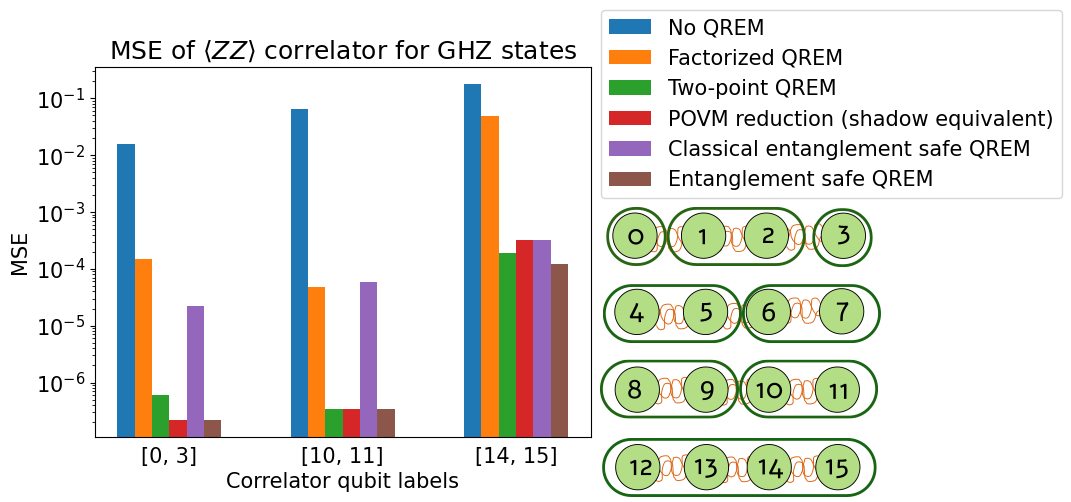

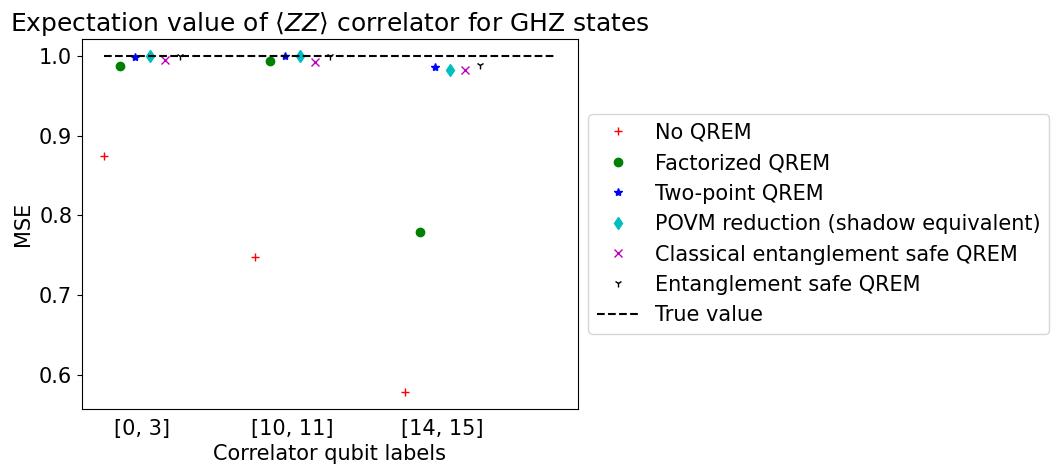

In [ ]:
# Plotting random correlator result
plt.rcParams.update({'font.size': 15})


with open(f'{data_path}/result_QST.npy', 'rb') as f:
    result_dict =  np.load(f, allow_pickle=True).item()

n_averages = result_dict['n_average']
two_point_corr_labels   = result_dict['two_point_corr_labels']
traced_down_rho_true_array = result_dict['traced_down_rho_true_array']

state_array, label_array = ot.load_state_array_from_result_dict(result_dict)

# Check if all states are physical 
print("Are alls states physical?")
print(ot.is_state_array_physical(state_array))

point_array = ['r+','go','b*','cd','mx','k1']

Z = np.array([[1,0],[0,-1]])

op_string = np.array([Z,Z])
op_string = [reduce(np.kron, op_string)]

exp_value_array = np.array([ot.compute_exp_value(item,op_string) for item in state_array])
true_exp_value = 1
MSE_array = np.array([ot.compute_MSE(true_exp_value, item) for item in exp_value_array])

corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]
x = np.arange(len(corr_x_label))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

img = plt.imread("cluster_image_small.png")
fig.figimage(img, 600, 5, zorder=3, alpha=1)


for attribute, measurement in zip(label_array, MSE_array):
    offset = width * multiplier
    print(measurement)
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.set_yscale('log')
ax.set_title(rf"MSE of $\langle ZZ \rangle$ correlator for GHZ states")


ax.set_xticks(x + 2.5*width, corr_x_label)

plt.ylabel('MSE')
plt.xlabel('Correlator qubit labels')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off


plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))

#plt.text(10, 0.3, text_string, fontsize=14,verticalalignment='top', bbox=props)

x = np.arange(len(corr_x_label))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement, point in zip(label_array, exp_value_array, point_array):
    offset = width * multiplier
    ax.plot(x + offset, measurement.flatten(), point, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.plot(np.arange(len(corr_x_label))*1.5, np.ones(len(corr_x_label)), 'k--', label =  'True value')	
ax.set_title(rf"Expectation value of $\langle ZZ \rangle$ correlator for GHZ states")


ax.set_xticks(x + 2.5*width, corr_x_label)

plt.ylabel('MSE')
plt.xlabel('Correlator qubit labels')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


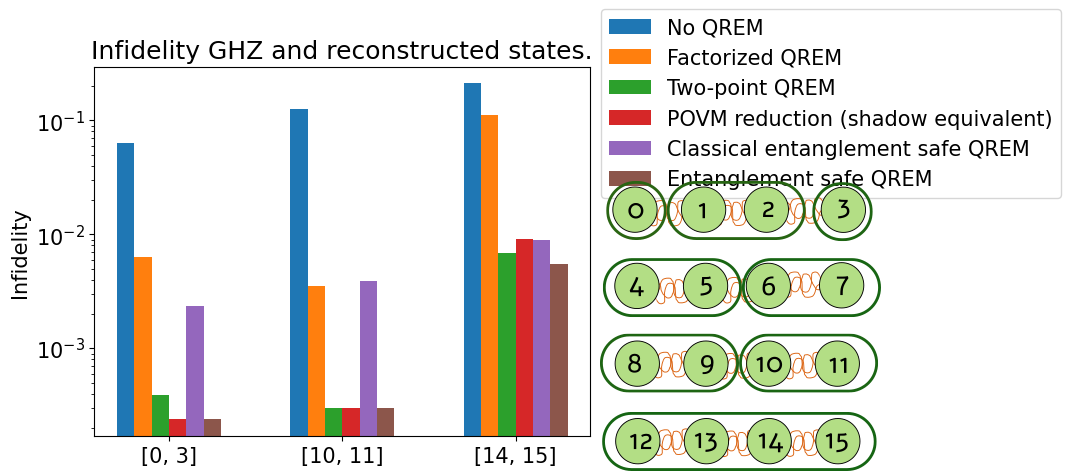

In [ ]:

# Plotting
#data_path = "QDOT_results/2024-08-01_13-23-06_9debe732-8fc3-49b5-bdde-ef8b208d43b5"
with open(f'{data_path}/result_QST.npy', 'rb') as f:
    result_dict =  np.load(f, allow_pickle=True).item()

n_averages = result_dict['n_average']
two_point_corr_labels   = result_dict['two_point_corr_labels']
traced_down_rho_true_array = result_dict['traced_down_rho_true_array']

state_array, label_array = ot.load_state_array_from_result_dict(result_dict)


#point_array = ['r+','go','b*','cd','mx','k1']

x = np.arange(len(corr_x_label))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots() 
img = plt.imread("cluster_image_small.png")
fig.figimage(img, 600, 5, zorder=3, alpha=1)
for attribute, state in zip(label_array, state_array):
    offset = width * multiplier
    rects = ax.bar(x + offset, ot.average_infidelities(state, traced_down_rho_true_array), width, label=attribute)
    multiplier += 1
ax.set_yscale('log')
ax.set_title(rf"Infidelity GHZ and reconstructed states.")
ax.set_xticks(x + 2.5*width, corr_x_label)
ax.set_ylabel('Infidelity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))

## Plot two different cases in one plot, one where we have the correct structure, one where we have the wrong structure

In [ ]:
true_cluster_labels = cl.get_true_cluster_labels(cluster_size)


one_qubit_POVMs = ot.reconstruct_all_one_qubit_POVMs(QDT_outcomes, n_qubits, hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)

prefect_noise_cluster_labels = true_cluster_labels
perfect_clustered_QDOT = ot.reconstruct_POVMs_from_noise_labels(QDT_outcomes, cl.get_true_cluster_labels(cluster_size), n_qubits,
                                                                hash_family, n_hash_symbols, one_qubit_calibration_states, n_cores)

noise_cluster_labels =  cl.find_noise_cluster_structure(QDT_outcomes, n_qubits, n_QDT_shots, hash_family, n_hash_symbols, 
                                                        one_qubit_calibration_states, n_cores)
clustered_QDOT = ot.reconstruct_POVMs_from_noise_labels(QDT_outcomes, noise_cluster_labels, n_qubits, hash_family, n_hash_symbols,
                                                        one_qubit_calibration_states, n_cores)
    
print(f"Perfect noise labels {prefect_noise_cluster_labels}")
print(f"Noise labels: {noise_cluster_labels}")
print(f"True labels: {true_cluster_labels}")

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  16 | elapsed:    4.5s remaining:   19.6s
[Parallel(n_jobs=9)]: Done   5 out of  16 | elapsed:    4.5s remaining:   10.0s
[Parallel(n_jobs=9)]: Done   7 out of  16 | elapsed:    4.5s remaining:    5.8s
[Parallel(n_jobs=9)]: Done   9 out of  16 | elapsed:    4.5s remaining:    3.5s
[Parallel(n_jobs=9)]: Done  11 out of  16 | elapsed:    8.5s remaining:    3.8s
[Parallel(n_jobs=9)]: Done  13 out of  16 | elapsed:    8.5s remaining:    1.9s
[Parallel(n_jobs=9)]: Done  16 out of  16 | elapsed:    8.5s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   8 | elapsed:    4.2s remaining:   12.8s
[Parallel(n_jobs=9)]: Done   3 out of   8 | elapsed:    6.3s remaining:   10.6s
[Parallel(n_jobs=9)]: Done   4 out of   8 | elapsed:    6.4s remaining:    6.4s
[Parallel(n_jobs=9)]: Done   5 out of   8 | elapsed:    6.5s

Create all possible 2 qubit POVMs for correlation map.
Number of 2 qubit POVMs to reconstruct: 120


[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   24.9s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   48.8s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    7.8s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   14.8s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   22.3s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   29.8s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   36.8s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   44.5s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:   57.7s
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:  1.1min
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:  1.3min
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:  1.6min remaining:    3.2s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:  1.7min finished


Alpha: 0.5
Inital partions: [[7, 6], [2, 1], [15, 13], [11, 10], [5, 4], [14, 12], [9, 8], [3, 0]]
Starting optimization of premade cluster structure.
Run: 0
New partition [[2, 1], [15, 13], [11, 10], [5, 4], [9, 8], [3, 0], [7, 6, 14], [12]]
Cost: 0.11670320531766887
New partition [[11, 10], [5, 4], [9, 8], [3, 0], [7, 6, 14], [12], [2, 1, 15], [13]]
Cost: 0.13064233851364604
New partition [[11, 10], [5, 4], [9, 8], [3, 0], [7, 6, 14], [13], [], [2, 1, 15, 12]]
Cost: 0.16243834574864713
New partition [[11, 10], [5, 4], [9, 8], [3, 0], [7, 6, 14], [], [15], [2, 1, 12, 13]]
Cost: 0.1683957111416685
New partition [[11, 10], [5, 4], [3, 0], [7, 6, 14], [], [15], [2, 1, 12, 13], [8], [9]]
Cost: 0.17457216526097397
Created a new parition!
New partition [[11, 10], [5, 4], [7, 6, 14], [], [2, 1, 12, 13], [8], [9], [0], [15, 3]]
Cost: 0.1996222498965331
New partition [[11, 10], [5, 4], [], [2, 1, 12, 13], [8], [9], [0], [7, 6, 14, 15], [3]]
Cost: 0.20538782457632587
Run: 1
New partition [[11, 

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   8 | elapsed:    4.5s remaining:   13.6s
[Parallel(n_jobs=9)]: Done   3 out of   8 | elapsed:    4.5s remaining:    7.6s
[Parallel(n_jobs=9)]: Done   4 out of   8 | elapsed:    4.5s remaining:    4.5s
[Parallel(n_jobs=9)]: Done   5 out of   8 | elapsed:    6.3s remaining:    3.8s
[Parallel(n_jobs=9)]: Done   6 out of   8 | elapsed:    6.4s remaining:    2.1s


Perfect noise labels [array([12, 13, 14, 15]), array([10, 11]), array([8, 9]), array([6, 7]), array([4, 5]), array([3]), array([1, 2]), array([0])]
Noise labels: [[11, 10], [5, 4], [8], [9], [0], [3], [2, 1, 13, 15], [7, 6, 14, 12]]
True labels: [array([12, 13, 14, 15]), array([10, 11]), array([8, 9]), array([6, 7]), array([4, 5]), array([3]), array([1, 2]), array([0])]


[Parallel(n_jobs=9)]: Done   8 out of   8 | elapsed:   43.8s finished


In [6]:
two_point_corr_labels = np.array([[5, 4],[6,7],[8,9], [13,15]])
# Reconstruct spesiffic two_point_povms
two_point_POVM = ot.reconstruct_spesific_two_qubit_POVMs(QDT_outcomes, two_point_corr_labels , n_qubits, hash_family, 
                                                         n_hash_symbols, one_qubit_calibration_states, n_cores)
hashed_QST_instructions = ot.create_hashed_instructions(hash_family, possible_QST_instructions, n_hash_symbols)


n_QST_shots_total = n_QST_shots *1
# Define the two point correlators to extract: 

# Perform comparative QST over many averaged random states. 
n_averages = 10
true_rho_average_array = []
traced_down_correlator_rho_true_array = []
start = time.time()
QST_outcomes_array = []
QST_outcomes_high_array = []

for k in range(n_averages):
    #if use_chunks:
    state_size_array = [chunk_size]*int(n_qubits/chunk_size)	# Set size to max to make sure state is entangled inside the chunk
    rho_true_array = [sf.generate_GHZ(size) for size in state_size_array] #[sf.generate_random_pure_state(size) for size in state_size_array]  #[sf.generate_GHZ(size) for size in state_size_array] 
    rho_true_labels = ot.get_true_cluster_labels(state_size_array)
    QST_outcomes = mf.measure_hashed_chunk_QST(n_QST_shots, chunk_size, povm_array, cluster_size, rho_true_array, state_size_array, hashed_QST_instructions)
    QST_outcomes_high =  mf.measure_hashed_chunk_QST(n_QST_shots*10, chunk_size, povm_array, cluster_size, rho_true_array, state_size_array, hashed_QST_instructions)
    rho_true_list, rho_labels_in_state = ot.tensor_chunk_states(rho_true_array, rho_true_labels, noise_cluster_labels, two_point_corr_labels)
    for i in range(len(two_point_corr_labels)):
        traced_down_rho_true = [ot.trace_down_qubit_state(rho_true_list[i], rho_labels_in_state[i], np.setdiff1d(rho_labels_in_state[i], two_point_corr_labels[i])) for i in range(len(rho_true_list))]
    traced_down_correlator_rho_true_array.append(traced_down_rho_true)
    # else:
    #     rho_true_array = np.array([sf.generate_random_pure_state(1) for _ in range(n_qubits)])
    #     QST_outcomes = mf.measure_cluster_QST(n_QST_shots, povm_array, rho_true_array, hashed_QST_instructions,  cluster_size)
    true_rho_average_array.append(rho_true_array)
    QST_outcomes_array.append(QST_outcomes)
    QST_outcomes_high_array.append(QST_outcomes_high)
# Perform QST measurements.

print(f'Sampling runtime for run {k}: {time.time()-start}')

if save_raw_data:
    with open(f'{data_path}/QST_outcome{k}.npy', 'wb') as f:
        np.save(f, QST_outcomes)



standard_result_QST_dict = ot.perform_full_comparative_QST(noise_cluster_labels, QST_outcomes_array, two_point_corr_labels, 
                                                  clustered_QDOT, one_qubit_POVMs, two_point_POVM, n_averages, data_path, 
                                                  hash_family, n_hash_symbols, n_qubits, n_cores)
    
standard_result_QST_dict["true_rho_average_array"] = true_rho_average_array
standard_result_QST_dict["traced_down_rho_true_array"] = traced_down_correlator_rho_true_array
standard_result_QST_dict["cluster_size"] = cluster_size
standard_result_QST_dict["noise_mode"] = noise_mode  
standard_result_QST_dict["n_QDT_shots"] = n_QDT_shots
standard_result_QST_dict["n_QST_shots"] = n_QST_shots

    
correct_clustering_result_QST_dict = ot.perform_full_comparative_QST(prefect_noise_cluster_labels, QST_outcomes_array, two_point_corr_labels, 
                                                  perfect_clustered_QDOT, one_qubit_POVMs, two_point_POVM, n_averages, data_path, 
                                                  hash_family, n_hash_symbols, n_qubits, n_cores)

    
correct_clustering_result_QST_dict["true_rho_average_array"] = true_rho_average_array
correct_clustering_result_QST_dict["traced_down_rho_true_array"] = traced_down_correlator_rho_true_array 
correct_clustering_result_QST_dict["cluster_size"] = cluster_size
correct_clustering_result_QST_dict["noise_mode"] = noise_mode
correct_clustering_result_QST_dict["n_QDT_shots"] = n_QDT_shots  
correct_clustering_result_QST_dict["n_QST_shots"] = n_QST_shots

exact_povm_result_QST_dict = ot.perform_full_comparative_QST(prefect_noise_cluster_labels, QST_outcomes_array, two_point_corr_labels, 
                                                  povm_array, one_qubit_POVMs, two_point_POVM, n_averages, data_path, 
                                                  hash_family, n_hash_symbols, n_qubits, n_cores)
    
exact_povm_result_QST_dict["true_rho_average_array"] = true_rho_average_array
exact_povm_result_QST_dict["traced_down_rho_true_array"] = traced_down_correlator_rho_true_array 
exact_povm_result_QST_dict["cluster_size"] = cluster_size
exact_povm_result_QST_dict["noise_mode"] = noise_mode
exact_povm_result_QST_dict["n_QDT_shots"] = n_QDT_shots  
exact_povm_result_QST_dict["n_QST_shots"] = n_QST_shots



high_QST_sampled_result_QST_dict = ot.perform_full_comparative_QST(prefect_noise_cluster_labels, QST_outcomes_high_array, two_point_corr_labels, 
                                                  povm_array, one_qubit_POVMs, two_point_POVM, n_averages, data_path, 
                                                  hash_family, n_hash_symbols, n_qubits, n_cores)

high_QST_sampled_result_QST_dict["true_rho_average_array"] = true_rho_average_array
high_QST_sampled_result_QST_dict["traced_down_rho_true_array"] = traced_down_correlator_rho_true_array 
high_QST_sampled_result_QST_dict["cluster_size"] = cluster_size
high_QST_sampled_result_QST_dict["noise_mode"] = noise_mode
high_QST_sampled_result_QST_dict["n_QDT_shots"] = n_QDT_shots  
high_QST_sampled_result_QST_dict["n_QST_shots"] = n_QST_shots


with open(f'{data_path}/result_QST.npy', 'wb') as f:
    np.save(f, standard_result_QST_dict)
    np.save(f, correct_clustering_result_QST_dict)
    np.save(f, exact_povm_result_QST_dict)
    np.save(f, high_QST_sampled_result_QST_dict)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:   23.9s remaining:   23.9s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:   23.9s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:   12.0s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:   12.1s remaining:   12.1s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:   12.2s finished


Sampling runtime for run 9: 40.663286447525024


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    4.3s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.5s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.4s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.6s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.6s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    4.6s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.9s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.5s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    4.7s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.5s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.2s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    5.6s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.2s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.3s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    2.1s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.3s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.7s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.3s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.6s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.2s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.2s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.5s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    2.5s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.5s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.6s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.4s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.3s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.2s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.2s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    1.2s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    2.9s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    4.0s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    2.8s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    2.4s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    3.0s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    2.8s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    2.7s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    4.7s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    4.1s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=9)]: Done   2 out of   4 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=9)]: Done   4 out of   4 | elapsed:    4.7s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.


In [ ]:

# Plotting
#data_path = "QDOT_results/2024-08-01_13-23-06_9debe732-8fc3-49b5-bdde-ef8b208d43b5"
with open(f'{data_path}/result_QST.npy', 'rb') as f:
    standard_result_QST_dict =  np.load(f, allow_pickle=True).item()
    correct_clustering_result_QST_dict = np.load(f, allow_pickle=True).item()
    exact_povm_result_QST_dict = np.load(f, allow_pickle=True).item()
    high_QST_sample_dict = np.load(f, allow_pickle=True).item()

n_averages = standard_result_QST_dict['n_average']
two_point_corr_labels   = standard_result_QST_dict['two_point_corr_labels']
traced_down_rho_true_array = standard_result_QST_dict['traced_down_rho_true_array']

standard_state_array, label_array = ot.load_state_array_from_result_dict(standard_result_QST_dict)
correct_clustering_state_array, _ = ot.load_state_array_from_result_dict(correct_clustering_result_QST_dict)
exact_state_array, _ = ot.load_state_array_from_result_dict(exact_povm_result_QST_dict)
high_sampled_QST_array, _ = ot.load_state_array_from_result_dict(high_QST_sample_dict)


x = np.arange(len(two_point_corr_labels))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0
if n_averages == 1:
    fig, ax = plt.subplots(5,1)
else:
    fig, ax = plt.subplots(4,1)


for i in range(len(label_array)): #attribute, cluster_state, perfect_state, unsampled_perfect_state_array in zip(label_array, state_from_cluster_array, perfect_state_array, unsampled_perfect_state_array):
    offset = width * multiplier
    rects = ax[0].bar(x + offset, ot.average_infidelities(correct_clustering_state_array[i], traced_down_rho_true_array), width, label=label_array[i])
    ax[0].plot(x + offset, ot.average_infidelities(exact_state_array[i], traced_down_rho_true_array), "co", label="Exact POVMs" if multiplier == 0 else "")
    ax[0].plot(x + offset, ot.average_infidelities(standard_state_array[i], traced_down_rho_true_array), "kx", label="Found clustering" if multiplier == 0 else "")
    ax[0].plot(x + offset, ot.average_infidelities(high_sampled_QST_array[i], traced_down_rho_true_array), "b*", label="High QST samples (Exact povm)" if multiplier == 0 else "")
    multiplier += 1
#lines_labels = ax[0].get_legend_handles_labels()
ax[0].plot([], [], ' ', label="Bars: Correct clustering but sampled POVMs")
#lines,labels = [lol for lol in zip(*lines_labels)]
ax[0].set_yscale('log')
ax[0].set_title(rf"Average over 10 GHZ states")
ax[0].set_xticks(x + 2.5*width, two_point_corr_labels)
ax[0].set_ylabel('Infidelity')

Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
op_string_array = np.array([[Z,Z],[X,X],[X,Z]])
op_label = [r'$\langle ZZ \rangle$',r'$\langle XX \rangle$', r'$\langle XZ \rangle$']
for j in range(len(op_string_array)):

    op_string = [reduce(np.kron, op_string_array[j])]
    true_exp_value = ot.compute_exp_value(traced_down_rho_true_array,op_string)
    standard_exp_value_array = np.array([ot.compute_exp_value(item,op_string) for item in standard_state_array])
    standard_MSE_array = np.array([ot.compute_MSE(true_exp_value, item) for item in standard_exp_value_array])
    
    correct_clustering_exp_value_array = np.array([ot.compute_exp_value(item,op_string) for item in correct_clustering_state_array])
    correct_clustering_MSE_array = np.array([ot.compute_MSE(true_exp_value, item) for item in correct_clustering_exp_value_array])

    exact_povm_exp_value_array = np.array([ot.compute_exp_value(item,op_string) for item in exact_state_array])
    exact_povm_MSE_array = np.array([ot.compute_MSE(true_exp_value, item) for item in exact_povm_exp_value_array])

    high_sampled_exp_value_array = np.array([ot.compute_exp_value(item,op_string) for item in high_sampled_QST_array])
    high_sampled_MSE_array = np.array([ot.compute_MSE(true_exp_value, item) for item in high_sampled_exp_value_array])
    corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]
    x = np.arange(len(corr_x_label))  # the label locations
    width = 0.1  # the width of the bars
    multiplier = 0

    if n_averages == 1:


        for i in range(len(label_array)):
            offset = width * multiplier
            ax[1+j*2].bar(x + offset, correct_clustering_exp_value_array[i].flatten(), width)
            ax[1+j*2].plot(x + offset, exact_povm_exp_value_array[i].flatten(), "co")
            ax[1+j*2].plot(x + offset, standard_exp_value_array[i].flatten(), "kx")
            ax[1+j*2].plot(x + offset, high_sampled_exp_value_array[i].flatten(), "b*")
            multiplier += 1
        shift = 1
        offset_true = -0.05
        for i in range(len(true_exp_value[0])):
            ax[1+j*2].plot(np.arange(len(true_exp_value[0]))*0.3 + shift*i + offset_true, np.ones(len(x))*true_exp_value.flatten()[i], 'k--', label = 'True exp. value' if (i == 0  and j == 0) else "" )
        ax[1+j*2].set_ylabel(op_label[j])


        multiplier = 0
        for i in range(len(label_array)):
            offset = width * multiplier
            rects = ax[2 + j*2].bar(x + offset, correct_clustering_MSE_array[i], width)
            ax[2 + j*2].plot(x + offset, exact_povm_MSE_array[i], "co")
            ax[2 + j*2].plot(x + offset, standard_MSE_array[i], "kx")
            ax[2 + j*2].plot(x + offset, high_sampled_MSE_array[i], "b*")
            #ax.bar_label(rects, padding=3)
            multiplier += 1
        ax[2 + j*2].set_yscale('log')
        #x[1].set_title(rf"MSE of $\langle XX \rangle$ correlator for Haar states")

        ax[2 + j*2].set_ylabel('MSE ' + op_label[j])

    else: # More than one average, not plotting exp values
        for i in range(len(label_array)):
            offset = width * multiplier
            rects = ax[1 + j].bar(x + offset, correct_clustering_MSE_array[i], width)
            ax[1 + j].plot(x + offset, exact_povm_MSE_array[i], "co")
            ax[1 + j].plot(x + offset, standard_MSE_array[i], "kx")
            ax[1 + j].plot(x + offset, high_sampled_MSE_array[i], "b*")
            #ax.bar_label(rects, padding=3)
            multiplier += 1
        ax[1 + j].set_yscale('log')
        ax[1 + j].set_ylabel('MSE ' + op_label[j])

for i in range(0, len(ax)-1): # Set all exect last axis zero
    ax[i].xaxis.set_visible(False)

ax[-1].set_xticks(x + 2.5*width, corr_x_label)

ax[-1].set_xticks(x + 2.5*width, corr_x_label)
ax[-1].set_xlabel('Correlator qubit labels')



plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

fig.legend(loc='center left', bbox_to_anchor=(0.95,0.75))
fig.text(0.95,0.6, f"Found clustering:\n {noise_cluster_labels[0:3]} \n {noise_cluster_labels[3:6]}\n {noise_cluster_labels[6:]} ", fontsize=12, verticalalignment='top')

img = plt.imread("images/cluster_image_small.png")
fig.figimage(img, 900, 100, zorder=3, alpha=1)


fig.set_size_inches(10, 10)


NameError: name 'data_path' is not defined

# Brute force perfect hash family search 

In [7]:
# Define the hash parameters you want. 

n = 16
k = 6
timeout = 300 #10 * 3600   # [seconds]
target_size = 5
timeout_start = time.time()

perfect_hash = ot.generate_kRDm_hash_brute(n,k)
best_hash = perfect_hash
size = len(perfect_hash)
it = 1
while time.time() < timeout_start + timeout:
    perfect_hash = ot.generate_kRDm_hash_brute(n,k)
    
    temp_size = len(perfect_hash)
    if temp_size < size:
        size = temp_size
        print(f'Hash length: {size}, iteration: {it},  time_found: {time.time() - timeout_start}')
        best_hash = perfect_hash
        if size == target_size:
            break
    it+=1
print(f"Time spent: {time.time() - timeout_start}.")
print(f"Best hash found: {len(best_hash)}")
path = "EMQST_lib/hash_family/"
print(best_hash)
with open(f'{path}perfect_hash({size},{n},{k}).npy', 'wb') as f:
    np.save(f, best_hash)

Time spent: 2.3902482986450195.
Best hash found: 8
[[0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3]
 [3 2 1 5 1 4 3 0 0 0 5 2 1 4 3 2]
 [4 3 2 4 5 5 1 0 2 0 3 1 3 1 0 2]
 [4 1 0 4 1 5 3 3 5 2 3 1 0 2 0 2]
 [1 4 2 0 2 0 1 0 3 3 5 2 4 5 1 3]
 [1 0 2 5 4 0 1 5 2 1 3 4 0 2 3 3]
 [1 2 4 0 5 0 3 0 1 5 2 3 4 1 2 3]
 [2 0 5 3 2 1 4 4 3 1 2 1 0 3 0 5]]


# Testbench for checking if using POVM reduction method works for entangled states. 

In [ ]:
# Comparing tracing down POVM vs tracing down final reconstructed state. 
bell_state = np.array([[1, 0, 0, 1], 
                       [0, 0, 0, 0], 
                       [0, 0, 0, 0], 
                       [1, 0, 0, 1]]) / 2
n_qubits = 2
n_QDT_shots = 10**4
print("Bell state density matrix:")
print(bell_state)
true_state = sf.generate_random_pure_state(n_qubits)
# Define nosy 2 qubit POVM
base_POVM = POVM.generate_computational_POVM(2)[0]
noisy_POVM = POVM.generate_noisy_POVM(base_POVM, noise_mode=3)
calib,_ = sf.get_calibration_states(n_qubits)
recon_POVM = dt.device_tomography(n_qubits,n_QDT_shots,[noisy_POVM],calib)
noisy_pauli_6 = POVM.generate_Pauli_from_comp(noisy_POVM)#POVM.generate_Pauli_POVM(n_qubits)
print(f'POVM distance:{sf.POVM_distance(noisy_POVM.get_POVM(),recon_POVM[0].get_POVM())}')
povm_list = np.array([povm.get_POVM() for povm in noisy_pauli_6])

outcomes = np.array([ povm.get_histogram(true_state) for povm in noisy_pauli_6])
n_qst_shot = 10**10
index_counts = outcomes *n_qst_shot
index_counts = index_counts.flatten()
two_qubit_povm = povm_list.copy()
# Reconstruct the  2 qubit state
two_qubit_povm = two_qubit_povm.reshape(-1,4,4)

two_qubit_rho_recon = QST.iterative_MLE_index(index_counts,two_qubit_povm)

two_qubit_trace_down_recon  = sf.partial_trace(two_qubit_rho_recon)
# Reconstruc the traced down state
povm_trace = np.array([[sf.partial_trace(element)for element in povm ] for povm in povm_list])
trace_down_rho_true = sf.partial_trace(true_state)



povm_trace = povm_trace.reshape(-1,2,2)

one_qubit_rho_recon = QST.iterative_MLE_index(index_counts,povm_trace)

print(f'Infidelity for traced down POVM: {sf.qubit_infidelity(one_qubit_rho_recon,trace_down_rho_true)}')
print(f'Infidelity for 2 qubit: {sf.qubit_infidelity(two_qubit_trace_down_recon,trace_down_rho_true)}')
print(f'Purity for traced down POVM: {sf.purity(one_qubit_rho_recon)}, {sf.purity(two_qubit_trace_down_recon)}, {sf.purity(trace_down_rho_true)}')

